In [1]:
import numpy as np
from numpy.ma import masked_values as maval
import gsw
import cmocean as ocean
import xarray as xr
import pandas as pd
import os.path as op
from xgcm import Grid
from datetime import datetime, timedelta
from scipy.interpolate import PchipInterpolator as pchip
from scipy.interpolate import interp1d
from scipy.signal import medfilt, medfilt2d
from scipy.ndimage.filters import gaussian_filter as gaus
import scipy.stats as stats
import dask.array as dsar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import matplotlib.colors as clr
import matplotlib.ticker as tick
import matplotlib.path as mpath
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
comdir = '/swot/SUM02/takaya/SOCCOM/SIO'
limdir = '/swot/SUM03/Argo_BGC_backscatter_SO_merged'

In [3]:
comdir = '/swot/SUM02/takaya/SOCCOM/SIO'
pf = pd.read_csv(op.join(comdir,'../Fronts/pf.txt'), delim_whitespace=True, 
                 nrows=968, header=None, dtype=float, names=['lon','lat'])
saf = pd.read_csv(op.join(comdir,'../Fronts/saf.txt'), delim_whitespace=True, 
                 nrows=1079, header=None, dtype=float, names=['lon','lat'])

In [4]:
comC = pd.read_csv(op.join(comdir,'SOCCOM_Cs.csv'),
                  infer_datetime_format=True, keep_date_col=True, parse_dates=['time']).drop(columns=['Unnamed: 0'])
comR = pd.read_csv(op.join(comdir,'SOCCOM_rates.csv'),
                   infer_datetime_format=True, keep_date_col=True, parse_dates=['time']).drop(columns=['Unnamed: 0'])
limC = pd.read_csv(op.join(limdir,'../Argo_Analysis/SOCLIM_Cs.csv'),
                   infer_datetime_format=True, keep_date_col=True, parse_dates=['time']).drop(columns=['Unnamed: 0'])
limR = pd.read_csv(op.join(limdir,'../Argo_Analysis/SOCLIM_rates.csv'),
                   infer_datetime_format=True, keep_date_col=True, parse_dates=['time']).drop(columns=['Unnamed: 0'])

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


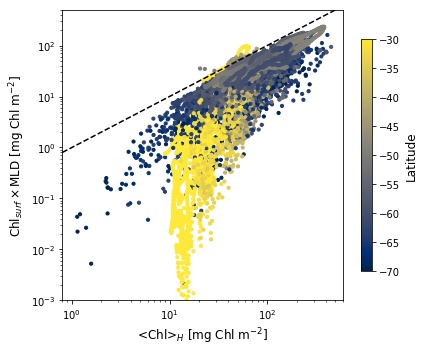

In [5]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
ax.plot(np.arange(1e3), np.arange(1e3), 'k--')
im = ax.scatter(comC.ChlH_rolled, comC.ChlsML_rolled, c=comC.Lat, vmin=-70, vmax=-30, s=10, cmap='cividis', rasterized=True)
ax.scatter(limC.ChlH_rolled, limC.ChlsML_rolled, c=limC.Lat, vmin=-70, vmax=-30, s=10, cmap='cividis', rasterized=True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([.8,6e2])
ax.set_ylim([.001,5e2])
ax.set_xlabel(r"<Chl>$_{H}$ [mg Chl m$^{-2}$]", fontsize=12)
ax.set_ylabel(r"Chl$_{surf}\times$MLD [mg Chl m$^{-2}$]", fontsize=12)
cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Latitude', fontsize=12)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.data is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Series.data is deprecated and will be removed in a future version
  if sys.path[0] == '':
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


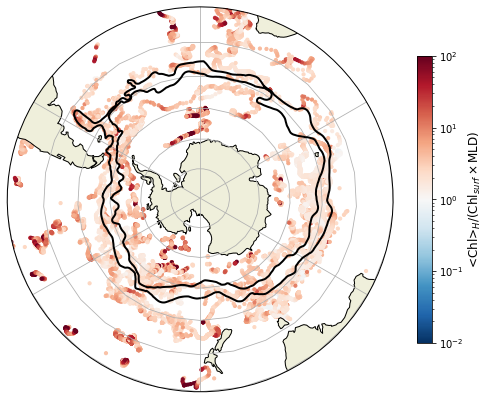

In [10]:
fig = plt.figure(figsize=(7,6))
fig.set_tight_layout(True)
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
ax.plot(pf.lon.data, (pf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax.plot(saf.lon.data, (saf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

im = ax.scatter(comC.Lon, comC.Lat, c=comC.ChlH_rolled/comC.ChlsML_rolled, vmin=0.01, vmax=100, s=10, 
                cmap='RdBu_r', norm=clr.LogNorm(), transform=ccrs.PlateCarree())
ax.scatter(limC.Lon, limC.Lat, c=limC.ChlH_rolled/limC.ChlsML_rolled, vmin=0.01, vmax=100, s=10, 
           cmap='RdBu_r', norm=clr.LogNorm(), transform=ccrs.PlateCarree())

cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label(r"<Chl>$_{H}$/(Chl$_{surf}\times$MLD)", fontsize=12)

In [11]:
subcomC0 = comC.where(comC.time>np.datetime64('2014-06-01')
                     ).where(comC.time<np.datetime64('2015-02-28')).dropna(subset=['time'])
subcomC1 = comC.where(comC.time>np.datetime64('2015-06-01')
                     ).where(comC.time<np.datetime64('2016-02-28')).dropna(subset=['time'])
subcomC2 = comC.where(comC.time>np.datetime64('2016-06-01')
                     ).where(comC.time<np.datetime64('2017-02-28')).dropna(subset=['time'])
subcomC3 = comC.where(comC.time>np.datetime64('2017-06-01')
                     ).where(comC.time<np.datetime64('2018-02-28')).dropna(subset=['time'])
subcomC4 = comC.where(comC.time>np.datetime64('2018-06-01')
                     ).where(comC.time<np.datetime64('2019-02-28')).dropna(subset=['time'])

subcomR0 = comR.where(comR.time>np.datetime64('2014-06-01')
                     ).where(comR.time<np.datetime64('2015-02-28')).dropna(subset=['time'])
subcomR1 = comR.where(comR.time>np.datetime64('2015-06-01')
                     ).where(comR.time<np.datetime64('2016-02-28')).dropna(subset=['time'])
subcomR2 = comR.where(comR.time>np.datetime64('2016-06-01')
                     ).where(comR.time<np.datetime64('2017-02-28')).dropna(subset=['time'])
subcomR3 = comR.where(comR.time>np.datetime64('2017-06-01')
                     ).where(comR.time<np.datetime64('2018-02-28')).dropna(subset=['time'])
subcomR4 = comR.where(comR.time>np.datetime64('2018-06-01')
                     ).where(comR.time<np.datetime64('2019-02-28')).dropna(subset=['time'])

In [12]:
sublimC2 = limC.where(limC.time>np.datetime64('2016-06-01')
                     ).where(limC.time<np.datetime64('2017-02-28')).dropna(subset=['time'])
sublimC3 = limC.where(limC.time>np.datetime64('2017-06-01')
                     ).where(limC.time<np.datetime64('2018-02-28')).dropna(subset=['time'])
sublimC4 = limC.where(limC.time>np.datetime64('2018-06-01')
                     ).where(limC.time<np.datetime64('2019-02-28')).dropna(subset=['time'])

sublimR2 = limR.where(limR.time>np.datetime64('2016-06-01')
                     ).where(limR.time<np.datetime64('2017-02-28')).dropna(subset=['time'])
sublimR3 = limR.where(limR.time>np.datetime64('2017-06-01')
                     ).where(limR.time<np.datetime64('2018-02-28')).dropna(subset=['time'])
sublimR4 = limR.where(limR.time>np.datetime64('2018-06-01')
                     ).where(limR.time<np.datetime64('2019-02-28')).dropna(subset=['time'])

In [13]:
groupLC2 = sublimC2.groupby('floatID')
groupLC3 = sublimC3.groupby('floatID')
groupLC4 = sublimC4.groupby('floatID')
i = 0
for name,group in groupLC2:
    grp = pd.DataFrame(group)
    if i == 0:
        Apl2 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        Onl2 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        Apl2 = pd.concat([Apl2,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                        'pEu','CH'])], 
                        ignore_index=True)
        Onl2 = pd.concat([Onl2,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                        'pEu','CH'])], 
                        ignore_index=True)
i = 0
for name,group in groupLC3:
    grp = pd.DataFrame(group)
    if i == 0:
        Apl3 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        Onl3 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        Apl3 = pd.concat([Apl3,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                         'pEu','CH'])], 
                        ignore_index=True)
        Onl3 = pd.concat([Onl3,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                         'pEu','CH'])], 
                        ignore_index=True)
i = 0
for name,group in groupLC4:
    grp = pd.DataFrame(group)
    if i == 0:
        Apl4 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        Onl4 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        Apl4 = pd.concat([Apl4,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                        'pEu','CH'])], 
                        ignore_index=True)
        Onl4 = pd.concat([Onl4,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                        'pEu','CH'])], 
                        ignore_index=True)

i = 0
for name,group in groupLC2:
    grp = pd.DataFrame(group)
    if i == 0:
        MLl2 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        MLl2 = pd.concat([MLl2,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                           'pEu','CH'])], 
                         ignore_index=True)
i = 0
for name,group in groupLC3:
    grp = pd.DataFrame(group)
    if i == 0:
        MLl3 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        MLl3 = pd.concat([MLl3,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                          'pEu','CH'])], 
                         ignore_index=True)
i = 0
for name,group in groupLC4:
    grp = pd.DataFrame(group)
    if i == 0:
        MLl4 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        MLl4 = pd.concat([MLl4,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                           'pEu','CH'])], 
                         ignore_index=True)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN axis encountered
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: All-NaN axis encountered
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: All-NaN axis encountered
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: All-NaN axis encountered


In [14]:
groupLR2 = sublimR2.groupby('floatID')
groupLR3 = sublimR3.groupby('floatID')
groupLR4 = sublimR4.groupby('floatID')
i = 0
for name,group in groupLR2:

    grp = pd.DataFrame(group)
    if i == 0:
        Cll2 = grp[grp.rPH==np.nanmax(grp.rPH)]
        i += 1
    else:
        Cll2 = pd.concat([Cll2,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                        ignore_index=True)

i = 0
for name,group in groupLR3:

    grp = pd.DataFrame(group)
    if i == 0:
        Cll3 = grp[grp.rPH==np.nanmax(grp.rPH)]
        i += 1
    else:
        Cll3 = pd.concat([Cll3,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                        ignore_index=True)

i = 0
for name,group in groupLR4:
    grp = pd.DataFrame(group)
    if i == 0:
        Cll4 = grp[grp.rPH==np.nanmax(grp.rPH)]
        i += 1
    else:
        Cll4 = pd.concat([Cll4,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                        ignore_index=True)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: All-NaN axis encountered
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: All-NaN axis encountered


In [15]:
groupCC0 = subcomC0.groupby('floatID')
groupCC1 = subcomC1.groupby('floatID')
groupCC2 = subcomC2.groupby('floatID')
groupCC3 = subcomC3.groupby('floatID')
groupCC4 = subcomC4.groupby('floatID')
i = 0
for name,group in groupCC0:
    grp = pd.DataFrame(group)
    if i == 0:
        Apc0 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        Onc0 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        Apc0 = pd.concat([Apc0,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                        'pEu','CH'])], 
                        ignore_index=True)
        Onc0 = pd.concat([Onc0,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                        'pEu','CH'])], 
                        ignore_index=True)
i = 0
for name,group in groupCC1:
    grp = pd.DataFrame(group)
    if i == 0:
        Apc1 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        Onc1 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        Apc1 = pd.concat([Apc1,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                        'pEu','CH'])], 
                        ignore_index=True)
        Onc1 = pd.concat([Onc1,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                        'pEu','CH'])], 
                        ignore_index=True)
i = 0
for name,group in groupCC2:
    grp = pd.DataFrame(group)
    if i == 0:
        Apc2 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        Onc2 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        Apc2 = pd.concat([Apc2,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                        'pEu','CH'])], 
                        ignore_index=True)
        Onc2 = pd.concat([Onc2,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                        'pEu','CH'])], 
                        ignore_index=True)
i = 0
for name,group in groupCC3:
    grp = pd.DataFrame(group)
    if i == 0:
        Apc3 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        Onc3 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        Apc3 = pd.concat([Apc3,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                         'pEu','CH'])], 
                        ignore_index=True)
        Onc3 = pd.concat([Onc3,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                         'pEu','CH'])], 
                        ignore_index=True)
i = 0
for name,group in groupCC4:
    grp = pd.DataFrame(group)
    if i == 0:
        Apc4 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        Onc4 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        Apc4 = pd.concat([Apc4,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                        'pEu','CH'])], 
                        ignore_index=True)
        Onc4 = pd.concat([Onc4,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                        'pEu','CH'])], 
                        ignore_index=True)

##################
i = 0
for name,group in groupCC0:
    grp = pd.DataFrame(group)
    if i == 0:
        MLc0 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        MLc0 = pd.concat([MLc0,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                           'pEu','CH'])], 
                         ignore_index=True)
i = 0
for name,group in groupCC1:
    grp = pd.DataFrame(group)
    if i == 0:
        MLc1 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        MLc1 = pd.concat([MLc1,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                           'pEu','CH'])], 
                         ignore_index=True)
i = 0
for name,group in groupCC2:
    grp = pd.DataFrame(group)
    if i == 0:
        MLc2 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        MLc2 = pd.concat([MLc2,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                           'pEu','CH'])], 
                         ignore_index=True)
i = 0
for name,group in groupCC3:
    grp = pd.DataFrame(group)
    if i == 0:
        MLc3 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        MLc3 = pd.concat([MLc3,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                          'pEu','CH'])], 
                         ignore_index=True)
i = 0
for name,group in groupCC4:
    grp = pd.DataFrame(group)
    if i == 0:
        MLc4 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        MLc4 = pd.concat([MLc4,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                           'pEu','CH'])], 
                         ignore_index=True)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: All-NaN axis encountered


In [17]:
groupCR0 = subcomR0.groupby('floatID')
groupCR1 = subcomR1.groupby('floatID')
groupCR2 = subcomR2.groupby('floatID')
groupCR3 = subcomR3.groupby('floatID')
groupCR4 = subcomR4.groupby('floatID')
i = 0
for name,group in groupCR0:
    grp = pd.DataFrame(group)
    if i == 0:
        Clc0 = grp[grp.rPH==np.nanmax(grp.rPH)]
        i += 1
    else:
        Clc0 = pd.concat([Clc0,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                        ignore_index=True)

i = 0
for name,group in groupCR1:
    grp = pd.DataFrame(group)
    if i == 0:
        Clc1 = grp[grp.rPH==np.nanmax(grp.rPH)]
        i += 1
    else:
        Clc1 = pd.concat([Clc1,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                        ignore_index=True)
        
i = 0
for name,group in groupCR2:
    grp = pd.DataFrame(group)
    if i == 0:
        Clc2 = grp[grp.rPH==np.nanmax(grp.rPH)]
        i += 1
    else:
        Clc2 = pd.concat([Clc2,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                        ignore_index=True)

i = 0
for name,group in groupCR3:
    grp = pd.DataFrame(group)
    if i == 0:
        Clc3 = grp[grp.rPH==np.nanmax(grp.rPH)]
        i += 1
    else:
        Clc3 = pd.concat([Clc3,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                        ignore_index=True)

i = 0
for name,group in groupCR4:
    grp = pd.DataFrame(group)
    if i == 0:
        Clc4 = grp[grp.rPH==np.nanmax(grp.rPH)]
        i += 1
    else:
        Clc4 = pd.concat([Clc4,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                        ignore_index=True)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:188: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:189: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:192: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:193: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:196: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:197: FutureWarning: Series.data is depreca

Text(0.5, 1.0, '$t_{ML}$')

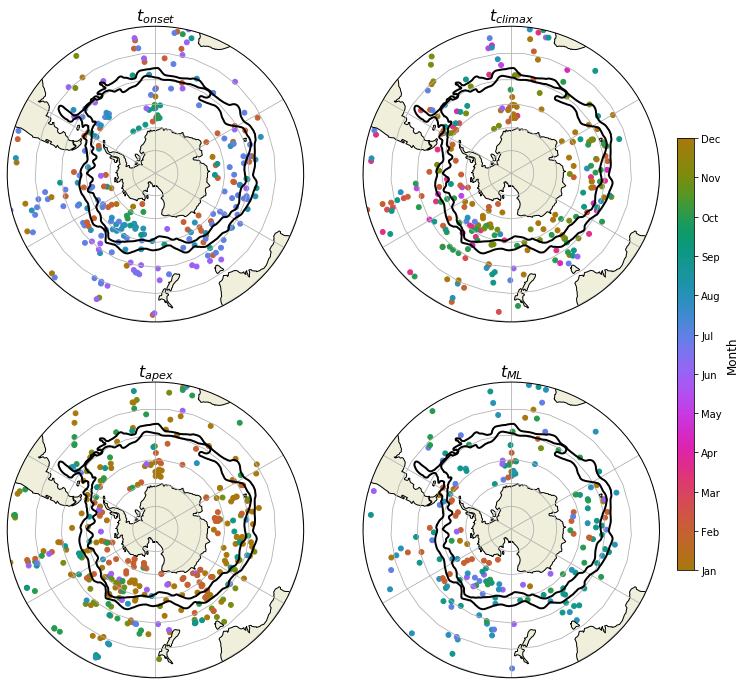

In [18]:
color = ocean.cm.phase
vm = 1
vM = 12
size=24
dm = 12

fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(2,2,1,projection=ccrs.SouthPolarStereo())
ax2 = fig.add_subplot(2,2,2,projection=ccrs.SouthPolarStereo())
ax3 = fig.add_subplot(2,2,3,projection=ccrs.SouthPolarStereo())
ax4 = fig.add_subplot(2,2,4,projection=ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND)
ax2.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND)
ax3.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax3.add_feature(cfeature.LAND)
ax4.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax2.set_boundary(circle, transform=ax2.transAxes)
ax3.set_boundary(circle, transform=ax3.transAxes)
ax4.set_boundary(circle, transform=ax4.transAxes)
month = pd.DatetimeIndex(Onc3.time).month.values
im1 = ax1.scatter(Onc3.Lon, Onc3.Lat, c=month, 
                 s=size, rasterized=True, cmap=color,
                 vmin=vm, vmax=vM,
                 transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Onc0.time).month.values
ax1.scatter(Onc0.Lon, Onc0.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Onc1.time).month.values
ax1.scatter(Onc1.Lon, Onc1.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Onc2.time).month.values
ax1.scatter(Onc2.Lon, Onc2.Lat, c=month,  
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Onc4.time).month.values
ax1.scatter(Onc4.Lon, Onc4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Onl3.time).month.values
ax1.scatter(Onl3.Lon, Onl3.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Onl4.time).month.values
ax1.scatter(Onl4.Lon, Onl4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())

month = pd.DatetimeIndex(Clc3.time).month.values
im2 = ax2.scatter(Clc3.Lon, Clc3.Lat, c=month, 
                 s=size, rasterized=True, cmap=color,
                 vmin=7, vmax=20,
                 transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Clc0.time).month.values
ax2.scatter(Clc0.Lon, Clc0.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Clc1.time).month.values
ax2.scatter(Clc1.Lon, Clc1.Lat, c=month,  
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Clc2.time).month.values
ax2.scatter(Clc2.Lon, Clc2.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Clc4.time).month.values
ax2.scatter(Clc4.Lon, Clc4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Cll2.time).month.values
ax2.scatter(Cll2.Lon, Cll2.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Cll3.time).month.values
ax2.scatter(Cll3.Lon, Cll3.Lat, c=month,  
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Cll4.time).month.values
ax2.scatter(Cll4.Lon, Cll4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())

month = pd.DatetimeIndex(Apc3.time).month.values
im3 = ax3.scatter(Apc3.Lon, Apc3.Lat, c=month, 
                 s=size, rasterized=True, cmap=color,
                 vmin=vm, vmax=vM,
                 transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Apc0.time).month.values
ax3.scatter(Apc0.Lon, Apc0.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Apc1.time).month.values
ax3.scatter(Apc1.Lon, Apc1.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Apc2.time).month.values
ax3.scatter(Apc2.Lon, Apc2.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Apc4.time).month.values
ax3.scatter(Apc4.Lon, Apc4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Apl2.time).month.values
ax3.scatter(Apl2.Lon, Apl2.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Apl3.time).month.values
ax3.scatter(Apl3.Lon, Apl3.Lat, c=month,  
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Apl4.time).month.values
ax3.scatter(Apl4.Lon, Apl4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())

month = pd.DatetimeIndex(MLc3.time).month.values
im4 = ax3.scatter(MLc3.Lon, MLc3.Lat, c=month, 
                 s=size, rasterized=True, cmap=color,
                 vmin=vm, vmax=vM,
                 transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(MLc0.time).month.values
ax4.scatter(MLc0.Lon, MLc0.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(MLc1.time).month.values
ax4.scatter(MLc1.Lon, MLc1.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(MLc2.time).month.values
ax4.scatter(MLc2.Lon, MLc2.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(MLc4.time).month.values
ax4.scatter(MLc4.Lon, MLc4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(MLl2.time).month.values
ax4.scatter(MLl2.Lon, MLl2.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(MLl3.time).month.values
ax4.scatter(MLl3.Lon, MLl3.Lat, c=month,  
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(MLl4.time).month.values
ax4.scatter(MLl4.Lon, MLl4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())

ax1.plot(pf.lon.data, (pf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax1.plot(saf.lon.data, (saf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines()
ax2.plot(pf.lon.data, (pf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax2.plot(saf.lon.data, (saf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines()
ax3.plot(pf.lon.data, (pf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax3.plot(saf.lon.data, (saf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.gridlines()
ax4.plot(pf.lon.data, (pf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax4.plot(saf.lon.data, (saf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.gridlines()
fig.subplots_adjust(right=0.88)
cbar_ax1 = fig.add_axes([0.9, 0.25, 0.02, 0.5])
cbar1 = fig.colorbar(im1, cax=cbar_ax1, ticks=[1,2,3,4,5,6,7,8,9,10,11,12])
cbar1.set_ticklabels(np.roll(np.asarray(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']), -0))
cbar1.set_label(r"Month", fontsize=12)

ax1.set_title(r"$t_{onset}$", fontsize=16)
ax2.set_title(r"$t_{climax}$", fontsize=16)
ax3.set_title(r"$t_{apex}$", fontsize=16)
ax4.set_title(r"$t_{ML}$", fontsize=16)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in less
/hom

Text(0.5, 1.0, 's60')

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


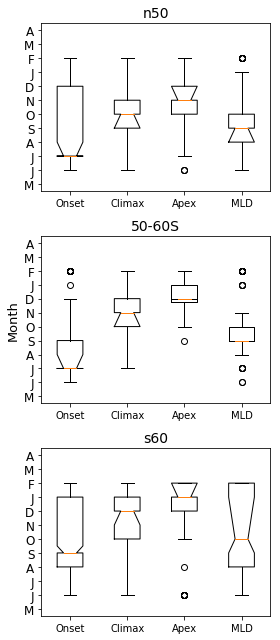

In [20]:
OnN = pd.DatetimeIndex(Onc0.where(Onc0.Lat>-50).time).month.values
OnN = np.append(OnN,pd.DatetimeIndex(Onc1.where(Onc1.Lat>-50).time).month.values)
OnN = np.append(OnN,pd.DatetimeIndex(Onc2.where(Onc2.Lat>-50).time).month.values)
OnN = np.append(OnN,pd.DatetimeIndex(Onc3.where(Onc3.Lat>-50).time).month.values)
OnN = np.append(OnN,pd.DatetimeIndex(Onc4.where(Onc4.Lat>-50).time).month.values)
OnN = np.append(OnN,pd.DatetimeIndex(Onl3.where(Onl3.Lat>-50).time).month.values)
OnN = np.append(OnN,pd.DatetimeIndex(Onl4.where(Onl4.Lat>-50).time).month.values)
OnN[OnN<5] += 12
OnN = np.ma.masked_invalid(OnN).compressed()
ClN = pd.DatetimeIndex(Clc0.where(Clc0.Lat>-50).time).month.values
ClN = np.append(ClN,pd.DatetimeIndex(Clc1.where(Clc1.Lat>-50).time).month.values)
ClN = np.append(ClN,pd.DatetimeIndex(Clc2.where(Clc2.Lat>-50).time).month.values)
ClN = np.append(ClN,pd.DatetimeIndex(Clc3.where(Clc3.Lat>-50).time).month.values)
ClN = np.append(ClN,pd.DatetimeIndex(Clc4.where(Clc4.Lat>-50).time).month.values)
ClN = np.append(ClN,pd.DatetimeIndex(Cll2.where(Cll2.Lat>-50).time).month.values)
ClN = np.append(ClN,pd.DatetimeIndex(Cll3.where(Cll3.Lat>-50).time).month.values)
ClN = np.append(ClN,pd.DatetimeIndex(Cll4.where(Cll4.Lat>-50).time).month.values)
ClN[ClN<5] += 12
ClN = np.ma.masked_invalid(ClN).compressed()
ApN = pd.DatetimeIndex(Apc0.where(Apc0.Lat>-50).time).month.values
ApN = np.append(ApN,pd.DatetimeIndex(Apc1.where(Apc1.Lat>=-50).time).month.values)
ApN = np.append(ApN,pd.DatetimeIndex(Apc2.where(Apc2.Lat>=-50).time).month.values)
ApN = np.append(ApN,pd.DatetimeIndex(Apc3.where(Apc3.Lat>=-50).time).month.values)
ApN = np.append(ApN,pd.DatetimeIndex(Apc4.where(Apc4.Lat>=-50).time).month.values)
ApN = np.append(ApN,pd.DatetimeIndex(Apl2.where(Apl2.Lat>=-50).time).month.values)
ApN = np.append(ApN,pd.DatetimeIndex(Apl3.where(Apl3.Lat>=-50).time).month.values)
ApN = np.append(ApN,pd.DatetimeIndex(Apl4.where(Apl4.Lat>=-50).time).month.values)
ApN[ApN<5] += 12
ApN = np.ma.masked_invalid(ApN).compressed()
MLN = pd.DatetimeIndex(MLc0.where(MLc0.Lat>-50).time).month.values
MLN = np.append(MLN,pd.DatetimeIndex(MLc1.where(MLc1.Lat>-50).time).month.values)
MLN = np.append(MLN,pd.DatetimeIndex(MLc2.where(MLc2.Lat>-50).time).month.values)
MLN = np.append(MLN,pd.DatetimeIndex(MLc3.where(MLc3.Lat>-50).time).month.values)
MLN = np.append(MLN,pd.DatetimeIndex(MLc4.where(MLc4.Lat>-50).time).month.values)
MLN = np.append(MLN,pd.DatetimeIndex(MLl2.where(MLl2.Lat>-50).time).month.values)
MLN = np.append(MLN,pd.DatetimeIndex(MLl3.where(MLl3.Lat>-50).time).month.values)
MLN = np.append(MLN,pd.DatetimeIndex(MLl4.where(MLl4.Lat>-50).time).month.values)
MLN[MLN<5] += 12
MLN = np.ma.masked_invalid(MLN).compressed()

OnM = pd.DatetimeIndex(Onc0.where(Onc0.Lat>=-60).where(Onc0.Lat<=-50).time).month.values
OnM = np.append(OnM,pd.DatetimeIndex(Onc1.where(Onc1.Lat>=-60).where(Onc1.Lat<=-50).time).month.values)
OnM = np.append(OnM,pd.DatetimeIndex(Onc2.where(Onc2.Lat>=-60).where(Onc2.Lat<=-50).time).month.values)
OnM = np.append(OnM,pd.DatetimeIndex(Onc3.where(Onc3.Lat>=-60).where(Onc3.Lat<=-50).time).month.values)
OnM = np.append(OnM,pd.DatetimeIndex(Onc4.where(Onc4.Lat>=-60).where(Onc4.Lat<=-50).time).month.values)
OnM = np.append(OnM,pd.DatetimeIndex(Onl3.where(Onl3.Lat>=-60).where(Onl3.Lat<=-50).time).month.values)
OnM = np.append(OnM,pd.DatetimeIndex(Onl4.where(Onl4.Lat>=-60).where(Onl4.Lat<=-50).time).month.values)
OnM[OnM<5] += 12
OnM = np.ma.masked_invalid(OnM).compressed()
ClM = pd.DatetimeIndex(Clc0.where(Clc0.Lat>=-60).where(Clc0.Lat<=-50).time).month.values
ClM = np.append(ClM,pd.DatetimeIndex(Clc1.where(Clc1.Lat>=-60).where(Clc1.Lat<=-50).time).month.values)
ClM = np.append(ClM,pd.DatetimeIndex(Clc2.where(Clc2.Lat>=-60).where(Clc2.Lat<=-50).time).month.values)
ClM = np.append(ClM,pd.DatetimeIndex(Clc3.where(Clc3.Lat>=-60).where(Clc3.Lat<=-50).time).month.values)
ClM = np.append(ClM,pd.DatetimeIndex(Clc4.where(Clc4.Lat>=-60).where(Clc4.Lat<=-50).time).month.values)
ClM = np.append(ClM,pd.DatetimeIndex(Cll2.where(Cll2.Lat>=-60).where(Cll2.Lat<=-50).time).month.values)
ClM = np.append(ClM,pd.DatetimeIndex(Cll3.where(Cll3.Lat>=-60).where(Cll3.Lat<=-50).time).month.values)
ClM = np.append(ClM,pd.DatetimeIndex(Cll4.where(Cll4.Lat>=-60).where(Cll4.Lat<=-50).time).month.values)
ClM[ClM<5] += 12
ClM = np.ma.masked_invalid(ClM).compressed()
ApM = pd.DatetimeIndex(Apc0.where(Apc0.Lat>=-60).where(Apc0.Lat<=-50).time).month.values
ApM = np.append(ApM,pd.DatetimeIndex(Apc1.where(Apc1.Lat>=-60).where(Apc1.Lat<=-50).time).month.values)
ApM = np.append(ApM,pd.DatetimeIndex(Apc2.where(Apc2.Lat>=-60).where(Apc2.Lat<=-50).time).month.values)
ApM = np.append(ApM,pd.DatetimeIndex(Apc3.where(Apc3.Lat>=-60).where(Apc3.Lat<=-50).time).month.values)
ApM = np.append(ApM,pd.DatetimeIndex(Apc4.where(Apc4.Lat>=-60).where(Apc4.Lat<=-50).time).month.values)
ApM = np.append(ApM,pd.DatetimeIndex(Apl2.where(Apl2.Lat>=-60).where(Apl2.Lat<=-50).time).month.values)
ApM = np.append(ApM,pd.DatetimeIndex(Apl3.where(Apl3.Lat>=-60).where(Apl3.Lat<=-50).time).month.values)
ApM = np.append(ApM,pd.DatetimeIndex(Apl4.where(Apl4.Lat>=-60).where(Apl4.Lat<=-50).time).month.values)
ApM[ApM<5] += 12
ApM = np.ma.masked_invalid(ApM).compressed()
MLM = pd.DatetimeIndex(MLc0.where(MLc0.Lat>=-60).where(MLc0.Lat<=-50).time).month.values
MLM = np.append(MLM,pd.DatetimeIndex(MLc1.where(MLc1.Lat>=-60).where(MLc1.Lat<=-50).time).month.values)
MLM = np.append(MLM,pd.DatetimeIndex(MLc2.where(MLc2.Lat>=-60).where(MLc2.Lat<=-50).time).month.values)
MLM = np.append(MLM,pd.DatetimeIndex(MLc3.where(MLc3.Lat>=-60).where(MLc3.Lat<=-50).time).month.values)
MLM = np.append(MLM,pd.DatetimeIndex(MLc4.where(MLc4.Lat>=-60).where(MLc4.Lat<=-50).time).month.values)
MLM = np.append(MLM,pd.DatetimeIndex(MLl2.where(MLl2.Lat>=-60).where(MLl2.Lat<=-50).time).month.values)
MLM = np.append(MLM,pd.DatetimeIndex(MLl3.where(MLl3.Lat>=-60).where(MLl3.Lat<=-50).time).month.values)
MLM = np.append(MLM,pd.DatetimeIndex(MLl4.where(MLl4.Lat>=-60).where(MLl4.Lat<=-50).time).month.values)
MLM[MLM<5] += 12
MLM = np.ma.masked_invalid(MLM).compressed()

OnS = pd.DatetimeIndex(Onc0.where(Onc0.Lat<-60).time).month.values
OnS = np.append(OnS,pd.DatetimeIndex(Onc1.where(Onc1.Lat<-60).time).month.values)
OnS = np.append(OnS,pd.DatetimeIndex(Onc2.where(Onc2.Lat<-60).time).month.values)
OnS = np.append(OnS,pd.DatetimeIndex(Onc3.where(Onc3.Lat<-60).time).month.values)
OnS = np.append(OnS,pd.DatetimeIndex(Onc4.where(Onc4.Lat<-60).time).month.values)
OnS = np.append(OnS,pd.DatetimeIndex(Onl3.where(Onl3.Lat<-60).time).month.values)
OnS = np.append(OnS,pd.DatetimeIndex(Onl4.where(Onl4.Lat<-60).time).month.values)
OnS[OnS<5] += 12
OnS = np.ma.masked_invalid(OnS).compressed()
ClS = pd.DatetimeIndex(Clc0.where(Clc0.Lat<-60).time).month.values
ClS = np.append(ClS,pd.DatetimeIndex(Clc1.where(Clc1.Lat<-60).time).month.values)
ClS = np.append(ClS,pd.DatetimeIndex(Clc2.where(Clc2.Lat<-60).time).month.values)
ClS = np.append(ClS,pd.DatetimeIndex(Clc3.where(Clc3.Lat<-60).time).month.values)
ClS = np.append(ClS,pd.DatetimeIndex(Clc4.where(Clc4.Lat<-60).time).month.values)
ClS = np.append(ClS,pd.DatetimeIndex(Cll2.where(Cll2.Lat<-60).time).month.values)
ClS = np.append(ClS,pd.DatetimeIndex(Cll3.where(Cll3.Lat<-60).time).month.values)
ClS = np.append(ClS,pd.DatetimeIndex(Cll4.where(Cll4.Lat<-60).time).month.values)
ClS[ClS<5] += 12
ClS = np.ma.masked_invalid(ClS).compressed()
ApS = pd.DatetimeIndex(Apc0.where(Apc0.Lat<-60).time).month.values
ApS = np.append(ApS,pd.DatetimeIndex(Apc1.where(Apc1.Lat<-60).time).month.values)
ApS = np.append(ApS,pd.DatetimeIndex(Apc2.where(Apc2.Lat<-60).time).month.values)
ApS = np.append(ApS,pd.DatetimeIndex(Apc3.where(Apc3.Lat<-60).time).month.values)
ApS = np.append(ApS,pd.DatetimeIndex(Apc4.where(Apc4.Lat<-60).time).month.values)
ApS = np.append(ApS,pd.DatetimeIndex(Apl2.where(Apl2.Lat<-60).time).month.values)
ApS = np.append(ApS,pd.DatetimeIndex(Apl3.where(Apl3.Lat<-60).time).month.values)
ApS = np.append(ApS,pd.DatetimeIndex(Apl4.where(Apl4.Lat<-60).time).month.values)
ApS[ApS<5] += 12
ApS = np.ma.masked_invalid(ApS).compressed()
MLS = pd.DatetimeIndex(MLc0.where(MLc0.Lat<-60).time).month.values
MLS = np.append(MLS,pd.DatetimeIndex(MLc1.where(MLc1.Lat<-60).time).month.values)
MLS = np.append(MLS,pd.DatetimeIndex(MLc2.where(MLc2.Lat<-60).time).month.values)
MLS = np.append(MLS,pd.DatetimeIndex(MLc3.where(MLc3.Lat<-60).time).month.values)
MLS = np.append(MLS,pd.DatetimeIndex(MLc4.where(MLc4.Lat<-60).time).month.values)
MLS = np.append(MLS,pd.DatetimeIndex(MLl2.where(MLl2.Lat<-60).time).month.values)
MLS = np.append(MLS,pd.DatetimeIndex(MLl3.where(MLl3.Lat<-60).time).month.values)
MLS = np.append(MLS,pd.DatetimeIndex(MLl4.where(MLl4.Lat<-60).time).month.values)
MLS[MLS<5] += 12
MLS = np.ma.masked_invalid(MLS).compressed()
OnClApN = [OnN, ClN, ApN, MLN]
OnClApM = [OnM, ClM, ApM, MLM]
OnClApS = [OnS, ClS, ApS, MLS]

fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(4,9))
fig.set_tight_layout(True)
ax1.boxplot(OnClApN, vert=True, notch=True, bootstrap=1000, labels=['Onset','Climax','Apex','MLD'])
ax1.set_ylim(4.5,16.5)
ax1.set_yticks([5,6,7,8,9,10,11,12,13,14,15,16])
ax1.set_yticklabels(['M','J','J','A','S','O','N','D','J','F','M','A'], fontsize=12)
ax2.boxplot(OnClApM, vert=True, notch=True, bootstrap=1000, labels=['Onset','Climax','Apex','MLD'])
ax2.set_ylim(4.5,16.5)
ax2.set_yticks([5,6,7,8,9,10,11,12,13,14,15,16])
ax2.set_yticklabels(['M','J','J','A','S','O','N','D','J','F','M','A'], fontsize=12)
ax2.set_ylabel(r"Month", fontsize=13)
ax3.boxplot(OnClApS, vert=True, notch=True, bootstrap=1000, labels=['Onset','Climax','Apex','MLD'])
ax3.set_ylim(4.5,16.5)
ax3.set_yticks([5,6,7,8,9,10,11,12,13,14,15,16])
ax3.set_yticklabels(['M','J','J','A','S','O','N','D','J','F','M','A'], fontsize=12)
ax1.set_title(r"n50", fontsize=14)
ax2.set_title(r"50-60S", fontsize=14)
ax3.set_title(r"s60", fontsize=14)

# Timelag between solstice

In [21]:
sols = np.array(['2014-06-21','2015-06-21','2016-06-21','2017-06-21','2018-06-21'], dtype='datetime64')
sols

array(['2014-06-21', '2015-06-21', '2016-06-21', '2017-06-21',
       '2018-06-21'], dtype='datetime64[D]')

In [27]:
k = 0
for i in Onc0.floatID.data:
    if (pd.DatetimeIndex(Onc0[Onc0.floatID==i].time).month < 10).all() and (pd.DatetimeIndex(Onc0[Onc0.floatID==i].time).month > 5).all():
        dt = np.asarray([Onc0[Onc0.floatID==i].time.values - sols[0]], dtype='timedelta64[D]')
        if dt < np.timedelta64(0):
            print('On0', i, Onc0[Onc0.floatID==i].time.values)
        if k == 0:
            OSc0 = dt
            OSc0_lat = Onc0[Onc0.floatID==i].Lat_rolled.values
            OSc0_lon = Onc0[Onc0.floatID==i].Lon_rolled.values
            k += 1
        else:
            OSc0 = np.append(OSc0, dt)
            OSc0_lat = np.append(OSc0_lat, Onc0[Onc0.floatID==i].Lat_rolled.values)
            OSc0_lon = np.append(OSc0_lon, Onc0[Onc0.floatID==i].Lon_rolled.values)
                
k = 0
for i in Onc1.floatID.data:
    if (pd.DatetimeIndex(Onc1[Onc1.floatID==i].time).month < 10).all() and (pd.DatetimeIndex(Onc1[Onc1.floatID==i].time).month > 5).all():
        dt = np.asarray([Onc1[Onc1.floatID==i].time.values - sols[1]], dtype='timedelta64[D]')
        if dt < np.timedelta64(0):
            print('Onc1', i, Onc1[Onc1.floatID==i].time.values)
        if k == 0:
            OSc1 = dt
            OSc1_lat = Onc1[Onc1.floatID==i].Lat_rolled.values
            OSc1_lon = Onc1[Onc1.floatID==i].Lon_rolled.values
            k += 1
        else:
            OSc1 = np.append(OSc1, dt)
            OSc1_lat = np.append(OSc1_lat, Onc1[Onc1.floatID==i].Lat_rolled.values)
            OSc1_lon = np.append(OSc1_lon, Onc1[Onc1.floatID==i].Lon_rolled.values)

k = 0
for i in Onc2.floatID.data:
    if (pd.DatetimeIndex(Onc2[Onc2.floatID==i].time).month < 10).all() and (pd.DatetimeIndex(Onc2[Onc2.floatID==i].time).month > 5).all():
        dt = np.asarray([Onc2[Onc2.floatID==i].time.values - sols[2]], dtype='timedelta64[D]')
        if dt < np.timedelta64(0):
            print('Onc2', i, Onc2[Onc2.floatID==i].time.values)
        if k == 0:
            OSc2 = dt
            OSc2_lat = Onc2[Onc2.floatID==i].Lat_rolled.values
            OSc2_lon = Onc2[Onc2.floatID==i].Lon_rolled.values
            k += 1
        else:
            OSc2 = np.append(OSc2, dt)
            OSc2_lat = np.append(OSc2_lat, Onc2[Onc2.floatID==i].Lat_rolled.values)
            OSc2_lon = np.append(OSc2_lon, Onc2[Onc2.floatID==i].Lon_rolled.values)
            
k = 0
for i in Onc3.floatID.data:
    if len(pd.DatetimeIndex(Onc3[Onc3.floatID==i].time).month) > 1:
        print(pd.DatetimeIndex(Onc3[Onc3.floatID==i].time).month)
        idxO = int(.5*len(pd.DatetimeIndex(Onc3[Onc3.floatID==i].time).month))
    else:
        idxO = 0
    if (pd.DatetimeIndex(Onc3[Onc3.floatID==i].time).month < 10).all() and (pd.DatetimeIndex(Onc3[Onc3.floatID==i].time).month > 5).all():
        dt = np.asarray([Onc3[Onc3.floatID==i].time.values[idxO] - sols[3]], dtype='timedelta64[D]')
        if k == 0:
            OSc3 = dt
            OSc3_lat = [Onc3[Onc3.floatID==i].Lat_rolled.values][idxO]
            OSc3_lon = [Onc3[Onc3.floatID==i].Lon_rolled.values][idxO]
            k += 1
        else:
            OSc3 = np.append(OSc3, dt)
            OSc3_lat = np.append(OSc3_lat, Onc3[Onc3.floatID==i].Lat_rolled.values[idxO])
            OSc3_lon = np.append(OSc3_lon, Onc3[Onc3.floatID==i].Lon_rolled.values[idxO])

k = 0
for i in Onc4.floatID.data:
    if (pd.DatetimeIndex(Onc4[Onc4.floatID==i].time).month < 10).all() and (pd.DatetimeIndex(Onc4[Onc4.floatID==i].time).month > 5).all():
        dt = np.asarray([Onc4[Onc4.floatID==i].time.values - sols[4]], dtype='timedelta64[D]')
        if dt < np.timedelta64(0):
            print('Onc2', i, Onc2[Onc2.floatID==i].time.values)
        if k == 0:
            OSc4 = dt
            OSc4_lat = Onc4[Onc4.floatID==i].Lat_rolled.values
            OSc4_lon = Onc4[Onc4.floatID==i].Lon_rolled.values
            k += 1
        else:
            OSc4 = np.append(OSc4, dt)
            OSc4_lat = np.append(OSc4_lat, Onc4[Onc4.floatID==i].Lat_rolled.values)
            OSc4_lon = np.append(OSc4_lon, Onc4[Onc4.floatID==i].Lon_rolled.values)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: Series.data is deprecated and will be removed in a future version


On0 4188.0 ['2014-06-04T12:00:00.000000000']
Onc1 4475.0 ['2015-06-01T12:00:00.000000000']
Onc1 4477.0 ['2015-06-02T12:00:00.000000000']
Onc2 4693.0 ['2016-06-09T12:00:00.000000000']
Onc2 4761.0 ['2016-06-07T12:00:00.000000000']
Onc2 4763.0 ['2016-06-18T12:00:00.000000000']
Onc2 4765.0 ['2016-06-10T12:00:00.000000000']


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: Series.data is deprecated and will be removed in a future version


Onc2 4397.0 ['2016-10-03T12:00:00.000000000']
Onc2 4677.0 ['2016-08-15T12:00:00.000000000']
Onc2 4678.0 ['2016-07-13T12:00:00.000000000']
Onc2 4761.0 ['2016-06-07T12:00:00.000000000']
Onc2 4763.0 ['2016-06-18T12:00:00.000000000']
Onc2 4846.0 []
Onc2 5077.0 ['2017-02-27T12:00:00.000000000']
Onc2 5100.0 []
Onc2 5107.0 []
Onc2 5108.0 []
Onc2 5132.0 []
Onc2 5134.0 []
Onc2 5366.0 []


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:69: FutureWarning: Series.data is deprecated and will be removed in a future version


In [24]:
k = 0
for i in Onl2.floatID.data:
    print(pd.DatetimeIndex(Onl2[Onl2.floatID==i].time).month)
    if pd.DatetimeIndex(Onl2[Onl2.floatID==i].time).month < 10 and pd.DatetimeIndex(Onl2[Onl2.floatID==i].time).month > 5:
        dt = np.asarray([Onl2[Onl2.floatID==i].time.values - sols[2]], dtype='timedelta64[D]')
        if dt < np.timedelta64(0):
            print(i, Onl2[Onl2.floatID==i].time.values)
        if k == 0:
            OSl2 = dt
            OSl2_lat = Onl2[Onl2.floatID==i].Lat_rolled.values
            OSl2_lon = Onl2[Onl2.floatID==i].Lon_rolled.values
            k += 1
        else:
            OSl2 = np.append(OSl2, dt)
            OSl2_lat = np.append(OSl2_lat, Onl2[Onl2.floatID==i].Lat_rolled.values)
            OSl2_lon = np.append(OSl2_lon, Onl2[Onl2.floatID==i].Lon_rolled.values)
            
                
k = 0
for i in Onl3.floatID.data:
    if pd.DatetimeIndex(Onl3[Onl3.floatID==i].time).month < 10 and pd.DatetimeIndex(Onl3[Onl3.floatID==i].time).month > 5:
        dt = np.asarray([Onl3[Onl3.floatID==i].time.values - sols[3]], dtype='timedelta64[D]')
        #         lat = .5*np.asarray([A3[A3.floatID==i].Lat_rolled.values + ML3[ML3.floatID==i].Lat_rolled.values])
        #         lon = .5*np.asarray([A3[A3.floatID==i].Lon_rolled.values + ML3[ML3.floatID==i].Lon_rolled.values])
        #         print(i, dt)
        if k == 0:
            OSl3 = dt
            OSl3_lat = Onl3[Onl3.floatID==i].Lat_rolled.values
            OSl3_lon = Onl3[Onl3.floatID==i].Lon_rolled.values
            k += 1
        else:
            OSl3 = np.append(OSl3, dt)
            OSl3_lat = np.append(OSl3_lat, Onl3[Onl3.floatID==i].Lat_rolled.values)
            OSl3_lon = np.append(OSl3_lon, Onl3[Onl3.floatID==i].Lon_rolled.values)

k = 0
for i in Onl4.floatID.data:
    if pd.DatetimeIndex(Onl4[Onl4.floatID==i].time).month < 10 and pd.DatetimeIndex(Onl4[Onl4.floatID==i].time).month > 5:
        dt = np.asarray([Onl4[Onl4.floatID==i].time.values - sols[4]], dtype='timedelta64[D]')
        if k == 0:
            OSl4 = dt
            OSl4_lat = Onl4[Onl4.floatID==i].Lat_rolled.values
            OSl4_lon = Onl4[Onl4.floatID==i].Lon_rolled.values
            k += 1
        else:
            OSl4 = np.append(OSl4, dt)
            OSl4_lat = np.append(OSl4_lat, Onl4[Onl4.floatID==i].Lat_rolled.values)
            OSl4_lon = np.append(OSl4_lon, Onl4[Onl4.floatID==i].Lon_rolled.values)

Int64Index([10], dtype='int64', name='time')
Int64Index([2], dtype='int64', name='time')
Int64Index([2], dtype='int64', name='time')
Int64Index([2], dtype='int64', name='time')
Int64Index([10], dtype='int64', name='time')
Int64Index([10], dtype='int64', name='time')
Int64Index([11], dtype='int64', name='time')
Int64Index([10], dtype='int64', name='time')


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:66: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:80: FutureWarning: Series.data is deprecated 

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: Series.data is deprecated and will be removed in a future version


Text(0.5, 1.0, '$t_{onset} - t_{sol}$')

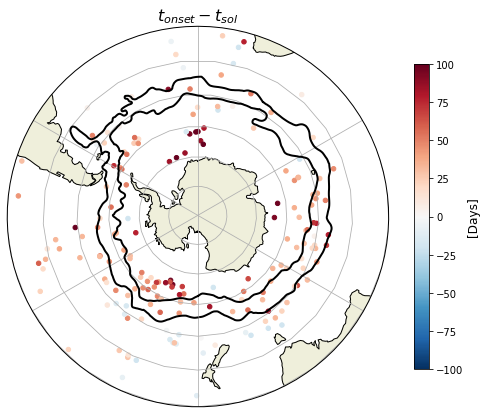

In [30]:
fig = plt.figure(figsize=(9,7))
ax1 = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)

im = ax1.scatter(OSc3_lon, OSc3_lat, c=OSc3, 
                 s=20., rasterized=True, cmap='RdBu_r',
                 vmin=-100, vmax=100,
                 transform=ccrs.PlateCarree())
ax1.scatter(OSc0_lon, OSc0_lat, c=OSc0, 
           s=20., rasterized=True, cmap='RdBu_r',
           vmin=-100, vmax=100,
           transform=ccrs.PlateCarree())
ax1.scatter(OSc1_lon, OSc1_lat, c=OSc1, 
           s=20., rasterized=True, cmap='RdBu_r',
           vmin=-100, vmax=100,
           transform=ccrs.PlateCarree())
ax1.scatter(OSc2_lon, OSc2_lat, c=OSc2, 
           s=20., rasterized=True, cmap='RdBu_r',
           vmin=-100, vmax=100,
           transform=ccrs.PlateCarree())
ax1.scatter(OSc4_lon, OSc4_lat, c=OSc4, 
           s=20., rasterized=True, cmap='RdBu_r',
           vmin=-100, vmax=100,
           transform=ccrs.PlateCarree())
ax1.scatter(OSl3_lon, OSl3_lat, c=OSl3, 
           s=20., rasterized=True, cmap='RdBu_r',
           vmin=-100, vmax=100,
           transform=ccrs.PlateCarree())
ax1.scatter(OSl4_lon, OSl4_lat, c=OSl4, 
           s=20., rasterized=True, cmap='RdBu_r',
           vmin=-100, vmax=100,
           transform=ccrs.PlateCarree())

ax1.plot(pf.lon.data, (pf.lat-1.).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax1.plot(saf.lon.data, (saf.lat+1.).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines()

cbar = fig.colorbar(im, ax=ax1, shrink=0.8)
cbar.set_label(r"[Days]", fontsize=12)
ax1.set_title(r"$t_{onset} - t_{sol}$", fontsize=16)

Text(0.5, 0, '$t_{onset} - t_{sol}$ [Days]')

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


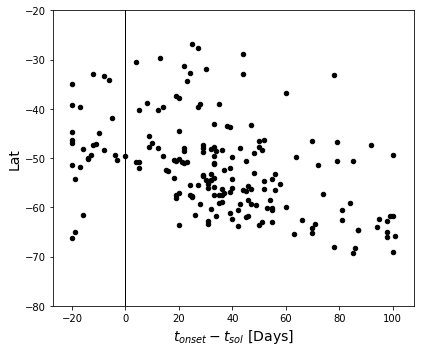

In [29]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
ax.plot(np.zeros(61),np.arange(-80,-19), 'k', lw=1)
ax.scatter(np.asarray(OSc0,dtype=float), OSc0_lat, c='k', s=20)
ax.scatter(np.asarray(OSc1,dtype=float), OSc1_lat, c='k', s=20)
ax.scatter(np.asarray(OSc2,dtype=float), OSc2_lat, c='k', s=20)
ax.scatter(np.asarray(OSc3,dtype=float), OSc3_lat, c='k', s=20)
ax.scatter(np.asarray(OSc4,dtype=float), OSc4_lat, c='k', s=20)
ax.scatter(np.asarray(OSl3,dtype=float), OSl3_lat, c='k', s=20)
ax.scatter(np.asarray(OSl4,dtype=float), OSl4_lat, c='k', s=20)

ax.set_ylim([-80,-20])
ax.set_ylabel(r"Lat", fontsize=14)
ax.set_xlabel(r"$t_{onset} - t_{sol}$ [Days]", fontsize=14)